# ASTR 596: The Midterm

#### 5 parts, 20 pts each. Some parts are easier than others, so are essentially free points, but you'll need to solve the earlier parts correctly to get the right answer on the later parts. I'd strongly recommend skimming the Riess et al. 2011 paper. 

#### We've been building up our ability to deal with complex data, and you've now got the ability to fit straight lines with frequentist tools (as you did with the Cepheids), and infer constraints on more complex high-dimensional models given the data with MCMC. So let's combine the two and infer one of the most important numbers in the Universe - the Hubble constant.

#### There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

#### Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file `R11ceph.dat`.

In [2]:
exec(open('cepheids.py').read())
ceph = Cepheids('R11ceph.dat')
hosts = ceph.list_hosts()

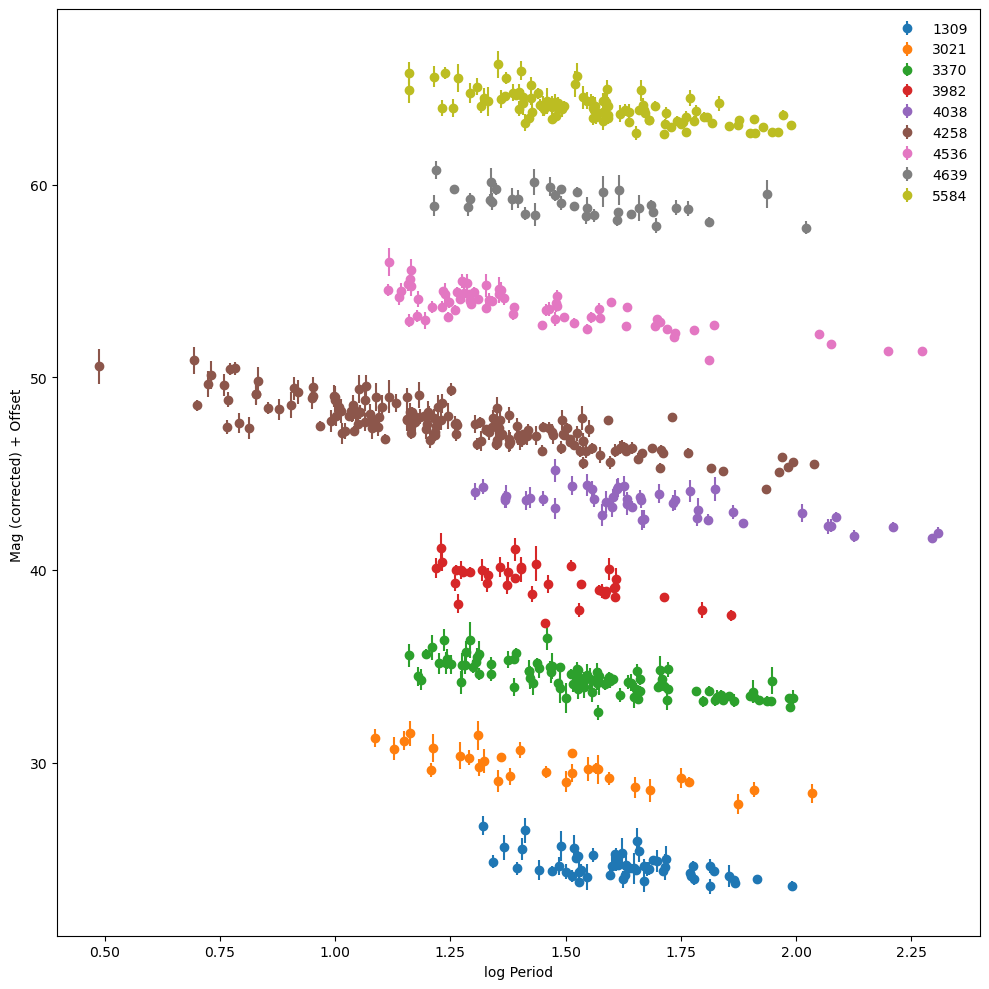

In [3]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID) # offset so they arent overlapping
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


### A1

The magnitude of the $j$th Cepheid in the $i$th host, is given by equation 1. When ignoring metalicity, the relation is:

$M(\mu_{0,i}, \log P_{i,j}) = m_{W,i,j} = (\mu_{0,i} - \mu_{0, 4258}) + zp_{4158} + b_W \log P_{i,j}$

- $\mu_{0,i} - \mu_{0, 4258}$ is the intercept and $b_W$ is the slope 

    - $\mu_{0,i}$ is the distance modulus of the host - this will be the same for all $j$ Cepheids, where $\mu_{0, 4258}$ is just for NGC 4258

    - $zp_{4258}$ is the intercept for the simulataneous fit (do I just take their constant for this)

Given the instrinstic Gaussian scatter, the probability of measuring $m_{W,i,j}$ of the $j$th Cepheid in the $i$th host is:

### $p(m_{W,i,j} | H) = \frac{1}{\sqrt{2\pi \sigma_{\text{int}}}} \exp \bigg( \frac{(m_{W,i,j} - M(\mu_{0,i}, \log P_{i,j}))^2}{2\sigma_{\text{int}}^2}\bigg)$

## Question: this feel correct, but what about the error in the measurement? isnt that normally sigma? - do i combine these/is sig int my error??

Then the log likelihood of measuring all of the $j$ Cepheids in host $i$ is as follows:

continuing as if its ok

$\begin{align} 
\ln L_i &= \log(\frac{1}{\sqrt{2\pi \sigma_{\text{int}}}}) +  \log(\exp \bigg( \frac{(m_{W,i,j} - M(\mu_{0,i}, \log P_{i,j}))^2}{2\sigma_{\text{int}}^2}\bigg)\\
    &= -\frac{1}{2} \log(2\pi \sigma_{\text{int}}) + \frac{1}{2}\displaystyle \sum_j \frac{(m_{W,i,j} - M(\mu_{0,i}, \log P_{i,j}))^2}{\sigma_{\text{int}}^2}\\
\end{align}$

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

I think the 2 parameters I am fitting are the intercept and slope.

## Assuming uniform?? - not sure I would know how to decide a gaussian prior, what more can I do here

Intercept $\mu_{0,i} - \mu_{0, 4258}$: $p(\mu_{0,i} - \mu_{0, 4258}) = U(-5,5)$ since the model is with respect to NGC 4258, I've selected this range because this includes stars with brightness that are within a factor of ~50 of the reference point.

Slope $b_W$: $p(b_W) = U(-10, -1)$ - Since magnitudes are backwards, decreasing values mean brighter object and we know that generally that for brighter cepheids they will have longer periods. (explains negative) cannot be zero since the luminoisity is a product of the star's radius changing regularly.

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [20]:
import scipy.stats as st
import emcee
import corner

In [142]:
def model(theta, logP):
    bW, mu = theta
    
    zp = 25.75 # was just an estimate - maybe I fit it to find the zp then do all the others
    return bW*logP + zp + mu 

In [50]:
def log_prior(theta):
    bW, mu = theta
    
    p_b = st.uniform.pdf(bW, loc=-10, scale=9) # -10 to -1
    p_mu = st.uniform.pdf(mu, loc=-5, scale=10) # -5 to 5
    
    return np.log(p_b*p_mu)

In [43]:
def log_likelihood(theta, logP, mobs, sigma):
    
    # computing the chi-squared
    diff = mobs - model(theta, logP)
    return -(0.5)*np.sum(2*np.pi*sigma**2) - (0.5)*np.sum((diff/sigma)**2)

In [44]:
def log_posterior(theta, logP, mobs, sigma):
    lnL = log_likelihood(theta, logP, mobs, sigma)
    lnpri = log_prior(theta)
    
    return lnL + lnpri

In [45]:
nwalkers = 5
ndim = 2 # just slope and int???
nburn = 1000
nsteps = 5000
sigmas = np.ones(ndim)

# making the same guess for all cepheids ig
guess = [-2, 1] # based on plot above

samples = [] # list of samples for each host
for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = np.array(ceph.mobs)
    logP = np.array(ceph.logP)
    sigma = np.array(ceph.sigma)
    
    args = (logP, mobs, sigma)
    kwargs = {'logP': logP, 'mobs': mobs, 'sigma':sigma}
    p0 = np.array(guess) + 0.1*sigmas*np.random.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, kwargs=kwargs)
    state = sampler.run_mcmc(p0, nburn)
    sampler.reset()
    _ = sampler.run_mcmc(state, nsteps, progress=True); # suppress! its ugly
    s = sampler.get_chain(flat=True)
    samples.append(s) 

C:\Users\Haille Perkins\AppData\Local\Temp\ipykernel_22064\4022751752.py:7: RuntimeWarning: divide by zero encountered in log
  return np.log(p_b*p_mu)
100%|██████████| 5000/5000 [00:18<00:00, 270.64it/s]


#### Checking validity of chains

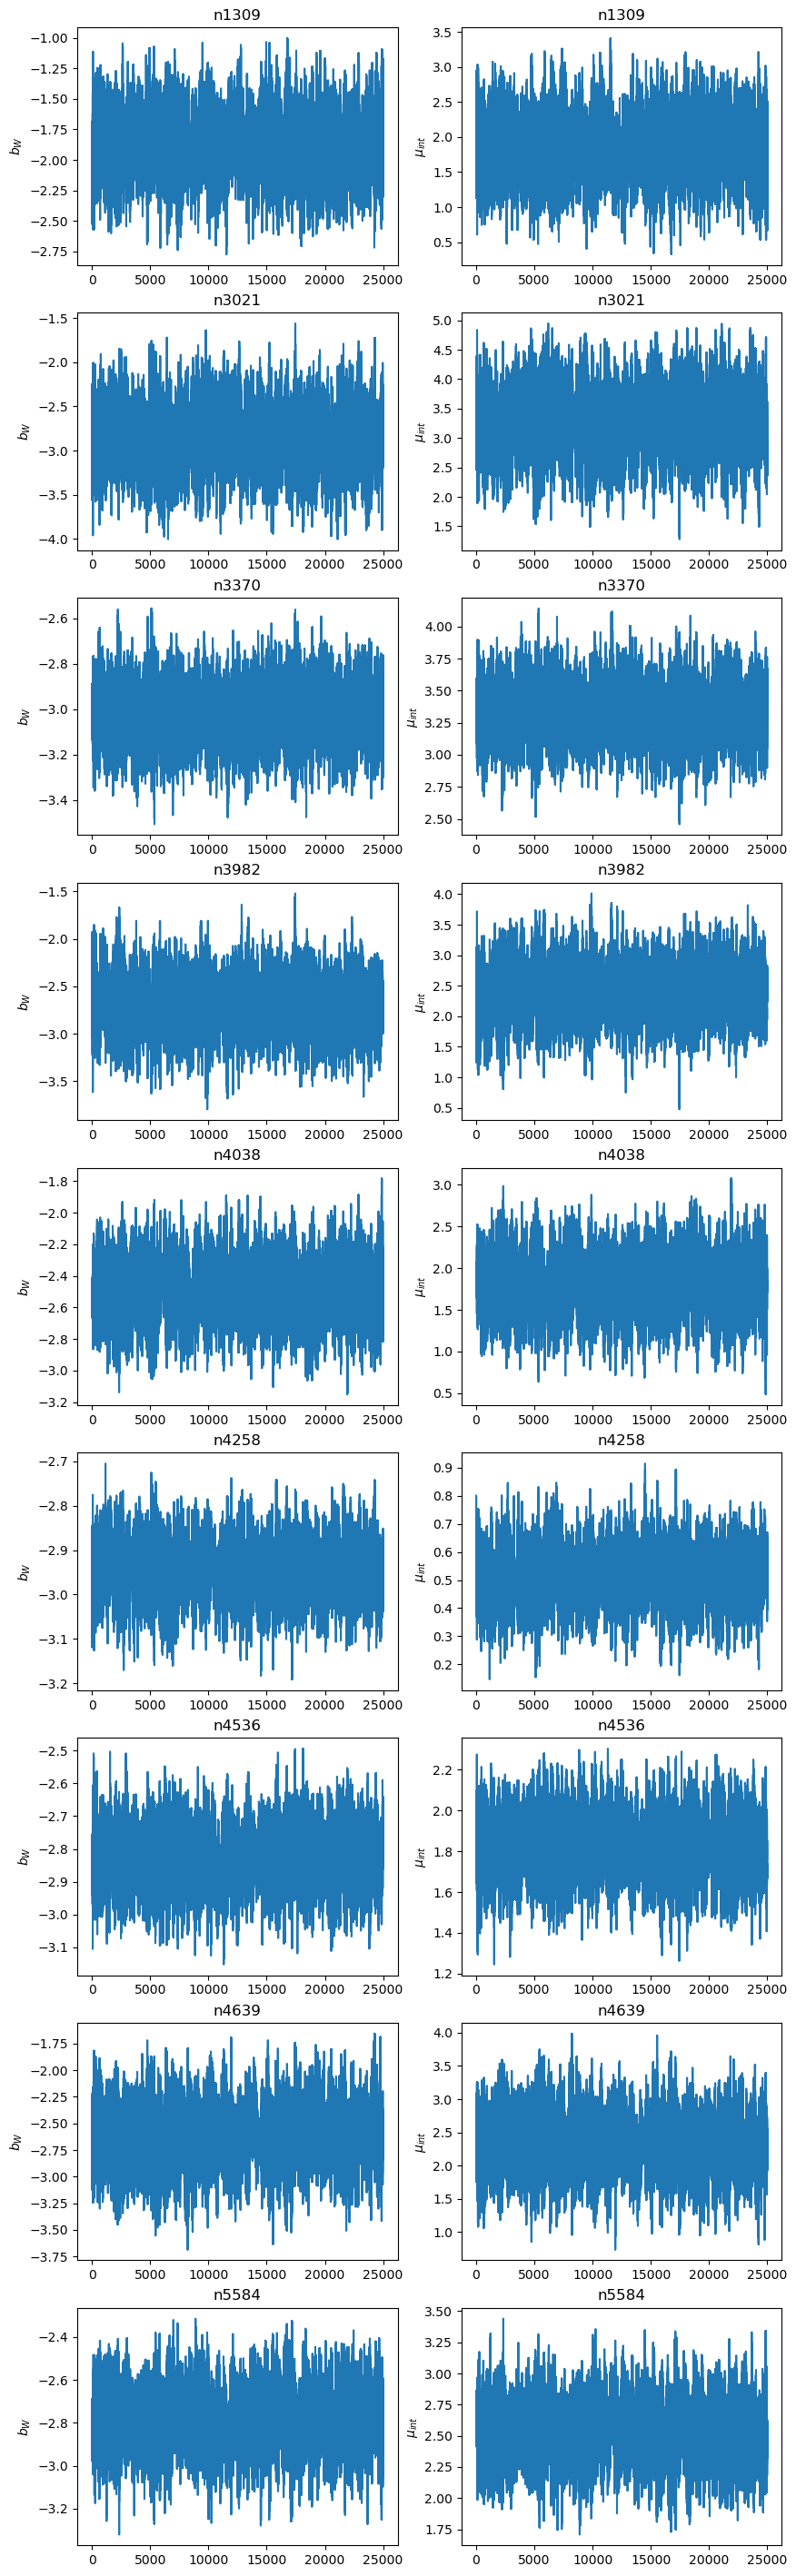

In [68]:
fig = plt.figure(figsize=(10, 36))
labels = [r'$b_W$', r'$\mu_{int}$']
for j in range(len(samples)):
    for i in range(ndim):
        ax = fig.add_subplot(9, 2, 2*j + i+1)
        ax.set_title("n"+ hosts[j])
        ax.set_ylabel(labels[i])
        ax.plot(samples[j][:,i])
        #if i == 0:
        #    ax.set_ylim(-10, 0)
        #else:
        #    ax.set_ylim(-3, 5)

The chains seems stationary! So now, I'll take the median of the values to be my parameters.

#### Figure 7 recreation

In [134]:
params = []
for host in samples:
    params.append(np.percentile(host, 50, axis=0))

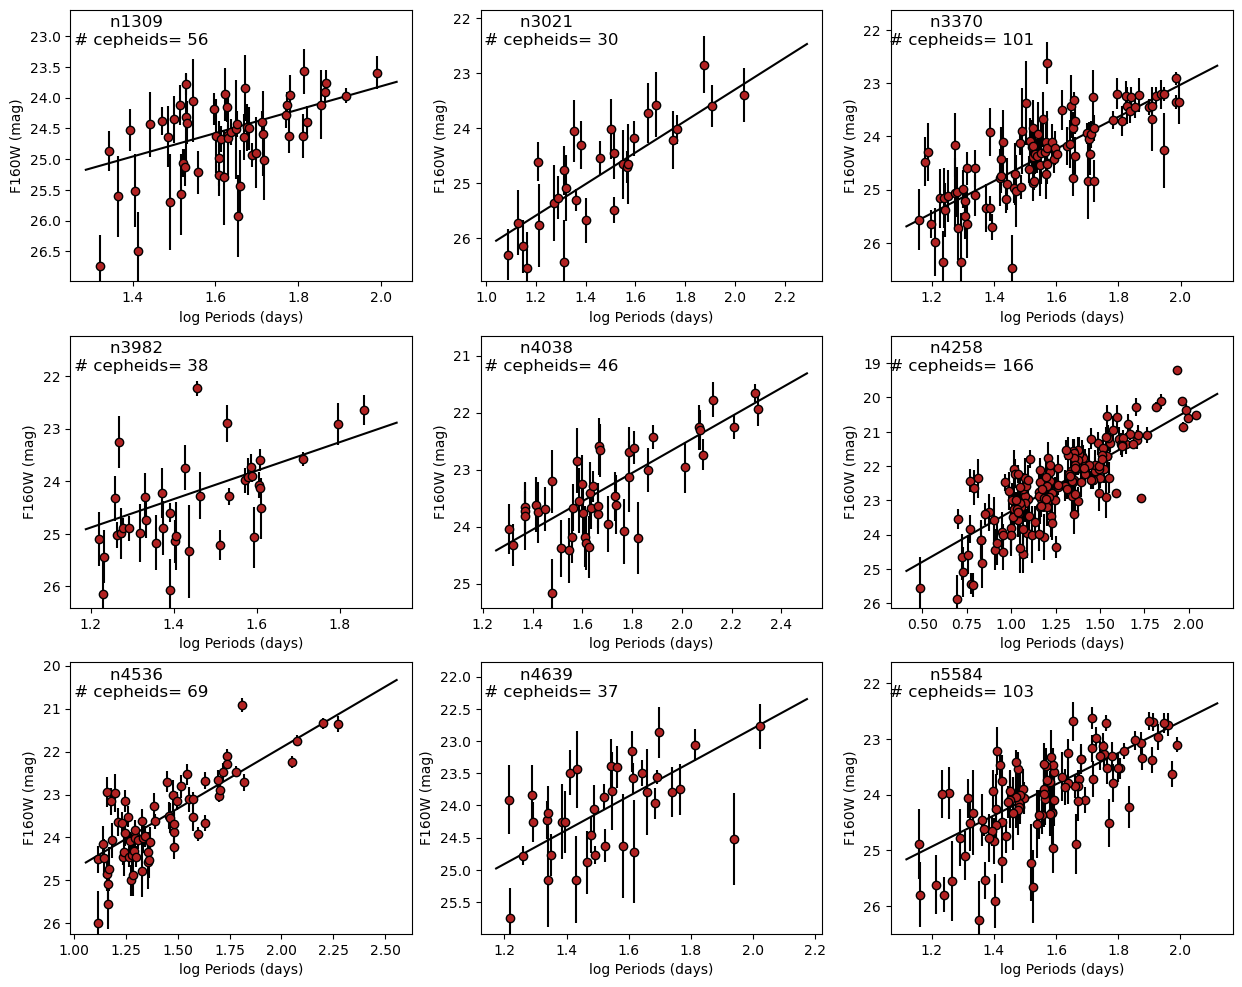

In [113]:
fig = plt.figure(figsize=(15, 12))
for i, ID in enumerate(hosts):
    ax = fig.add_subplot(3,3,i+1)
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs, yerr=sigma_obs, 
                linestyle='None', marker='o', 
                ecolor='black', color='firebrick', markeredgecolor='black',
                label=ID)
    
    pmin, pmax = ax.get_xlim()
    parr = np.arange(pmin, pmax+0.25, 0.25)
    ax.plot(parr, model(params[i], parr), color='black')
    ax.set_ylim(mobs.min()-1, mobs.max()+0.25) # make room for title
    ax.invert_yaxis()
    title = f"n%s \n # cepheids= %d" % (ID, len(mobs)) 
    ax.set_title(title, x=0.2, y=1.0, pad=-25)
    ax.set_xlabel("log Periods (days)")
    ax.set_ylabel("F160W (mag)")

#### Comparing to Table 3:

In [140]:
params[:,-1] # the last value in the list in the intercept

array([1.87402807, 3.26112201, 3.320995  , 2.37306309, 1.78642078,
       0.51919936, 1.8236436 , 2.31568581, 2.53194062])

In [141]:
hosts

array(['1309', '3021', '3370', '3982', '4038', '4258', '4536', '4639',
       '5584'], dtype='<U11')

$\begin{array}{c|c}
\text{NGC} & \text{MCMC} & \text{Table 3} \\
\hline
1309 & 1.874 &  3.276\\
3021 & 3.261 & 3.138 \\
3370 & 3.321 & 2.835 \\
3982 & 2.373 & 2.475 \\
4038 & 1.786& 2.396 \\
4258 & 0.519 & 0 \\
4536 & 1.824 & 1.567 \\
4639 & 2.316 & 2.383 \\
5584 & 2.532 & 2.461 \\
\end{array}$

1309 is the most different, but most are fairly close.

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

Let $\mu_{int} = \mu_{0,i} - \mu_{0,4258}$. These are the intercepts determined above.

Equation 3: $m^0_{v,i} = (\mu_{0,i} - \mu_{0,4258}) + m^0_{v,4258} = \mu_{int} + m^0_{v,4258}$

Equation 4: $\log H_0 = \large \frac{(m^0_{v,4258} - \mu_{0,4258}) + 5a_v + 25}{5} $

Then using equation 3: $m^0_{v,4258} = m^0_{v,i} - \mu_{int} $

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.